In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

import tensorflow as tf
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

IMG_SIZE=224

Using TensorFlow backend.


In [2]:
import os
print(os.listdir('../input/'))

['aptos2019-blindness-detection', 'densenet-keras']


In [3]:
# training/testデータの読み込み
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

# データの形状の確認
print(train_df.shape)
print(test_df.shape)

# trainingデータの確認
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [4]:
def crop_img(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

def preprocess_image(image_path, size=IMG_SIZE):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_img(img)
    img = cv2.resize(img, (size, size))
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), 10), -4, 128)
    return img

In [5]:
N = train_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_id}.png')

100%|██████████| 3662/3662 [09:48<00:00,  6.22it/s]


In [6]:
# テストデータも同様に読み込みます
N = test_df.shape[0]
x_test = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(f'../input/aptos2019-blindness-detection/test_images/{image_id}.png')

100%|██████████| 1928/1928 [02:02<00:00, 15.80it/s]


In [7]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
#> (3662, 224, 224, 3)
print(y_train.shape)
#> (3662, 5)
print(x_test.shape)
#> (1928, 224, 224, 3)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [8]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

ラベル[0, 1, 2, 3, 4]をCNNで学習できるように[[0, 0, 0, 0, 1], [0, 0, 0, 1, 0],...]のように、ダミー変数に変換する

In [9]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]
for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

In [10]:
for i in range(3, -1, -1):
    print(i)

3
2
1
0


In [11]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [12]:
y_train_multi

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [13]:
y_train[1, 1]

0

In [14]:
y_train_temp = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_temp

array([[168,  18, 120,  92, 227],
       [127,   0,   0, 168,  18],
       [120,  92, 227, 127,   0],
       ...,
       [ 13,   0,  54,  15,   1],
       [ 51,   9,   0,  54,  15],
       [  1,  52,  16,   0,  48]], dtype=uint8)

In [15]:
y_train_temp = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_temp[:, 4] = y_train[:, 4]

In [16]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [17]:
y_train_temp

array([[248,  18, 120,  92,   0],
       [127,   0,   0, 248,   1],
       [120,  92, 227, 127,   0],
       ...,
       [  0,   3,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=uint8)

In [18]:
print(y_train_temp[1, 4])
print(y_train[1, 3])

1
0


In [19]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [20]:
y_train_multi

array([[1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0]], dtype=uint8)

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train_multi, test_size=0.15)

In [22]:
BATCH_SIZE = 32

# インスタンスを作成
# zoom_range: 拡大縮小
# fill_mode: 入力画像の境界周りの埋め込み方
# cval: 境界周辺で利用される値
# holizontal_flip: 左右反転
# vertical_flip: 上下反転
# rotation_range: 回転

train_datagen = ImageDataGenerator(zoom_range=0.15, fill_mode='constant', cval=0, horizontal_flip=True, vertical_flip=True, rotation_range=360)

# ジェネレータを作成
# 拡張した画像データのバッチを生成する
data_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [23]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []
    
    def on_epoch_end(self, epoch, logs={}):
        X_valid, y_valid = self.validation_data[:2]
        # 例) sum([1, 1, 0, 0, 0]) - 1 = 2 - 1 = 1
        # 上記のように計算することで元のラベルを算出できる
        y_valid = y_valid.sum(axis=1) - 1

        # 例) [0.52, 0.8, 0.3, 0.2, 0.4]>0.5 →[1, 1, 0, 0, 0]
        y_pred = self.model.predict(X_valid) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        # 真の値'y_valid'と予測値'y_pred'を用いて重み付き(='quadratic')カッパ係数を計算
        _val_kappa = cohen_kappa_score(y_valid, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)

        print(f'valid_kappa: {_val_kappa: .4f}')

        # 計算したカッパ係数が精度が上がっているか確認
        if _val_kappa == max(self.val_kappas):
            print('validation kappa has improved. Saving model...')
            # 'model.h5'という名前でモデルを保存
            self.model.save('model.h5')
        return

In [24]:
densenet = DenseNet121(weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [25]:
model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [27]:
kappa_metrics = Metrics()

history = model.fit_generator(data_generator, steps_per_epoch=x_train.shape[0]/BATCH_SIZE, epochs=15, validation_data=(x_valid, y_valid), callbacks=[kappa_metrics])

Epoch 1/15
98/97 [==============================] - 131s 1s/step - loss: 0.2397 - accuracy: 0.8974 - val_loss: 0.3280 - val_accuracy: 0.9196
valid_kappa:  0.7420
validation kappa has improved. Saving model...
Epoch 2/15
98/97 [==============================] - 53s 540ms/step - loss: 0.1585 - accuracy: 0.9362 - val_loss: 0.2741 - val_accuracy: 0.9033
valid_kappa:  0.7460
validation kappa has improved. Saving model...
Epoch 3/15
98/97 [==============================] - 52s 535ms/step - loss: 0.1384 - accuracy: 0.9447 - val_loss: 0.1291 - val_accuracy: 0.9502
valid_kappa:  0.8700
validation kappa has improved. Saving model...
Epoch 4/15
98/97 [==============================] - 52s 535ms/step - loss: 0.1438 - accuracy: 0.9423 - val_loss: 0.1548 - val_accuracy: 0.9407
valid_kappa:  0.8349
Epoch 5/15
98/97 [==============================] - 53s 536ms/step - loss: 0.1296 - accuracy: 0.9495 - val_loss: 0.2268 - val_accuracy: 0.9131
valid_kappa:  0.7186
Epoch 6/15
98/97 [=======================

In [28]:
history_df = pd.DataFrame(history.history) 
history_df.head()

,val_loss,val_accuracy,loss,accuracy
0,0.328038,0.919636,0.240305,0.897429
1,0.274147,0.903273,0.158975,0.936183
2,0.129131,0.950182,0.138780,0.944666
3,0.154835,0.940727,0.141781,0.942288
4,0.226774,0.913091,0.128091,0.949486


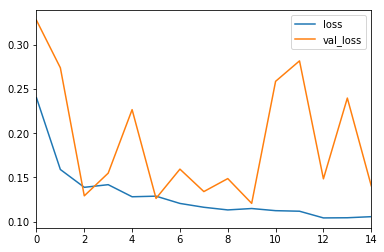

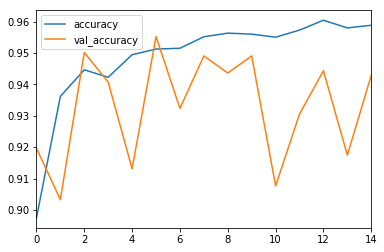

In [29]:
history_df[['loss', 'val_loss']].plot() 
history_df[['accuracy', 'val_accuracy']].plot()

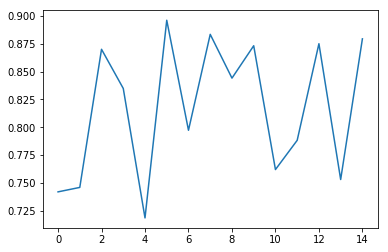

In [30]:
# 評価関数の推移を可視化
plt.plot(kappa_metrics.val_kappas)

In [31]:
# model作成時、精度が向上すると'model.h5'という名前で重みを保存していたので、model.h5にはもっとも良い重みが格納されている
model.load_weights('model.h5')

# テストデータで予測値を計算し、ラベルを変換する
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

# test_dfの'diagnosis'カラムを置き換える
test_df['diagnosis'] = y_test
# 提出用ファイルに変換する
test_df.to_csv('submission.csv', index=False)